# Recreating the KamLAND-Zen Limits on $m_{\beta\beta}$

### Append path because this file is not in the main directory

In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../")

### Import stuff

In [2]:
import nudobe
from nudobe import EFT, functions, constants
from EFT import LEFT
from matplotlib import pyplot as plt
import pandas as pd
import functions as f
import numpy as np
from constants import *

### Set parameters

First we, obviously, need to store the half-life limit obtained within KamLAND-Zen

In [3]:
#KamLAND-Zen limit
#https://arxiv.org/abs/2203.02139
half_life = 2.3e+26

Now we want to reproduce the obtained limits on $m_{\beta\beta}$ for all the different NME methods shown in the KamLAND-Zen paper. Hence, we need to use the same NMEs and PSFs as they used. They reference two papers with calculation of the PSFs by means of the RADIAL package. We don't know which values they actually took but the difference is marginal so we just decide to use the one given by Kotilla et al.

In [4]:
#PSF
G01 = 14.58e-15/V_ud**4

Now we need the NMEs (check NME definitions for factors)

In [5]:
NMEs = {"EDF(1)"  : 4.773,   #PhysRevLett.111.142501
        "EDF(2)"  : 4.32,    #PhysRevC.91.024316 (used g_M = k*g_V, instead of (1+k)) but not rescalable from paper
        "EDF(3)"  : 4.2,     #PhysRevLett.105.252503
        "QRPA(1)" : 3.009,   #PhysRevC.91.024613 #2.91 in the paper but they have g_M = k*g_V instead of (1+k)*g_V
        "QRPA(2)" : 3.384,   #PhysRevC.102.044303
        "QRPA(3)" : 2.460,   #PhysRevC.87.045501
        "QRPA(4)" : 1.89,    #PhysRevC.87.064302
        "QRPA(5)" : 1.18,    #PhysRevC.97.045503
        "IBM2(1)" : 3.387,   #PhysRevD.102.095016 #rescaled using g_A = 1.271
        "IBM2(2)" : 3.05,    #PhysRevC.91.034304
        "SM(1)"   : 2.39,    #PhysRevC.101.044315
        "SM(2)"   : 1.76,    #PhysRevC.91.024309
        "SM(3)"   : 1.77,    #Nucl.Phys.A 818 (2009) 139-151
        "SM(4)"   : 2.45,    #J Menéndez 2018 J. Phys. G: Nucl. Part. Phys. 45 014003
       }

In [6]:
MFsd = {"EDF(1)"  : 0,       #PhysRevLett.111.142501
        "EDF(2)"  : 0,       #PhysRevC.91.024316
        "EDF(3)"  : 0,       #PhysRevLett.105.252503
        "QRPA(1)" : -61.8,   #PhysRevC.91.024613
        "QRPA(2)" : 0,       #PhysRevC.102.044303
        "QRPA(3)" : 0,       #PhysRevC.87.045501
        "QRPA(4)" : 0,       #PhysRevC.87.064302
        "QRPA(5)" : -28.8,   #PhysRevC.97.045503
        "IBM2(1)" : -29.8,   #PhysRevD.102.095016 #rescaled using g_A = 1.271
        "IBM2(2)" : -29.7,   #PhysRevC.91.034304
        "SM(1)"   : 0,       #PhysRevC.101.044315
        "SM(2)"   : 0,       #PhysRevC.91.024309
        "SM(3)"   : 0,       #Nucl.Phys.A 818 (2009) 139-151
        "SM(4)"   : -52,     #Nucl.Phys.A 818 (2009) 139-151
       }

In [7]:
pd.DataFrame({r"$M_\nu$"    : list(NMEs.values()), 
              r"$M_{F,sd}$" : np.array(list(MFsd.values()))*m_e*m_p/m_pi**2,
              r"$M_{F,sd}/M_\nu$" : np.array(list(MFsd.values()))*m_e*m_p/m_pi**2/np.array(list(NMEs.values()))
             }, list(NMEs.keys())).T

,EDF(1),EDF(2),EDF(3),QRPA(1),QRPA(2),QRPA(3),QRPA(4),QRPA(5),IBM2(1),IBM2(2),SM(1),SM(2),SM(3),SM(4)
$M_\nu$,4.773,4.32,4.2,3.009000,3.384,2.46,1.89,1.180000,3.387000,3.050000,2.39,1.76,1.77,2.450000
"$M_{F,sd}$",0.000,0.00,0.0,-1.521084,0.000,0.00,0.00,-0.708855,-0.733468,-0.731006,0.00,0.00,0.00,-1.279876
"$M_{F,sd}/M_\nu$",0.000,0.00,0.0,-0.505511,0.000,0.00,0.00,-0.600724,-0.216554,-0.239674,0.00,0.00,0.00,-0.522398


To generate EFT models it is convenient to store the NMEs as a .csv file in the 'NMEs/' folder. We do so by initiating a LEFT model class, setting the NMEs appropriately and storing them in a .csv file in the correct folder.

In [8]:
#generate a model class
model = LEFT({})

In [9]:
#set all NMEs to 0
for col in model.NMEpanda.columns:
    model.NMEpanda[col].values[:] = 0

In [10]:
#Set M_GT^AA = M_nu and store as csv
for nme in NMEs:
    model.NMEpanda["136Xe"]["GTAA"] = NMEs[nme]
    model.NMEpanda["136Xe"]["Fsd"]     = 0#MFsd[nme]
    model.NMEpanda.to_csv("../NMEs/"+nme+".csv")

## Get Limits

Now we can calculate the limits on $m_{\beta\beta}$ (Note: The warning is generated from missing NMEs for the non-standard mechanisms. Hence, we don't need to care about them here.)

In [11]:
#store the limits in a dict
limits = {}
for nme in NMEs:
    model = LEFT({}, method = nme)
    model.PSFpanda["136Xe"]["G01"] = G01
    limits[nme] = model.get_limits(half_life, "136Xe")["Limits"]["m_bb"] * 1e+9

/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-ma

In [12]:
#generate a DataFrame from the limits
pd.DataFrame({r"$m_{\beta\beta}$": list(limits.values())}, limits.keys()).T

,EDF(1),EDF(2),EDF(3),QRPA(1),QRPA(2),QRPA(3),QRPA(4),QRPA(5),IBM2(1),IBM2(2),SM(1),SM(2),SM(3),SM(4)
$m_{\beta\beta}$,0.036191,0.039985,0.041128,0.057407,0.051045,0.070218,0.091395,0.146388,0.051,0.056635,0.072275,0.098146,0.097592,0.070505


Thus the limits are in the range of

In [13]:
min(limits.values())

0.03619051741691466

In [14]:
max(limits.values())

0.14638757595841834

## Generate Figure

Generating Datapoints...
Datapoints Generated
Preparing plot...
Generating plot


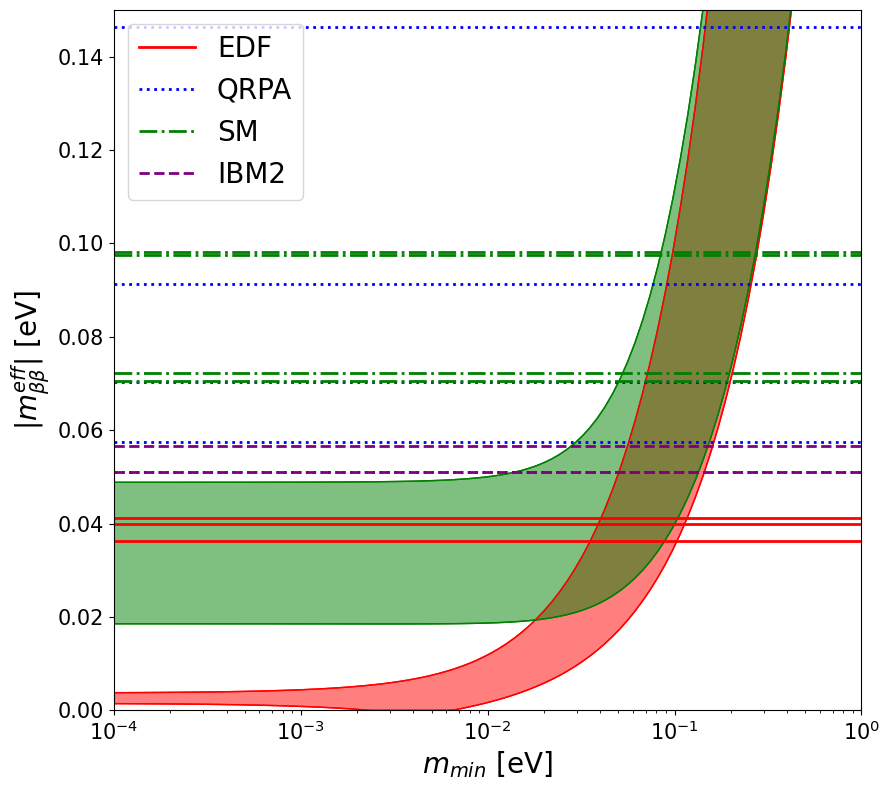

In [15]:
linewidth = 2
plotlims = {"EDF(1)"  : {"limit"     : limits["EDF(1)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth, 
                         "label"     : "EDF"}, 
            "EDF(2)"  : {"limit"     : limits["EDF(2)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth}, 
            "EDF(3)"  : {"limit"     : limits["EDF(3)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth},
            "QRPA(1)" : {"limit"     : limits["QRPA(1)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth, 
                         "label"     : "QRPA"}, 
            "QRPA(2)" : {"limit"     : limits["QRPA(2)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(3)" : {"limit"     : limits["QRPA(3)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(4)" : {"limit"     : limits["QRPA(4)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(5)" : {"limit"     : limits["QRPA(5)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "SM(1)"   : {"limit"     : limits["SM(1)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth, 
                         "label"     : "SM"}, 
            "SM(2)"   : {"limit"     : limits["SM(2)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth},
            "SM(3)"   : {"limit"     : limits["SM(3)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "SM(4)"   : {"limit"     : limits["SM(4)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "IBM2(1)" : {"limit"     : limits["IBM2(1)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth, 
                         "label"     : "IBM2"},
            "IBM2(2)" : {"limit"     : limits["IBM2(2)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth}}
fig = LEFT({}).plot_m_eff(limits    = plotlims, 
                          autolabel = False, 
                          colorNO   = "red", 
                          colorIO   = "green", 
                          yscale    = "linear", 
                          y_max     = 0.15,
                          y_min     = 0,
                         )

Add text for the mass ordering

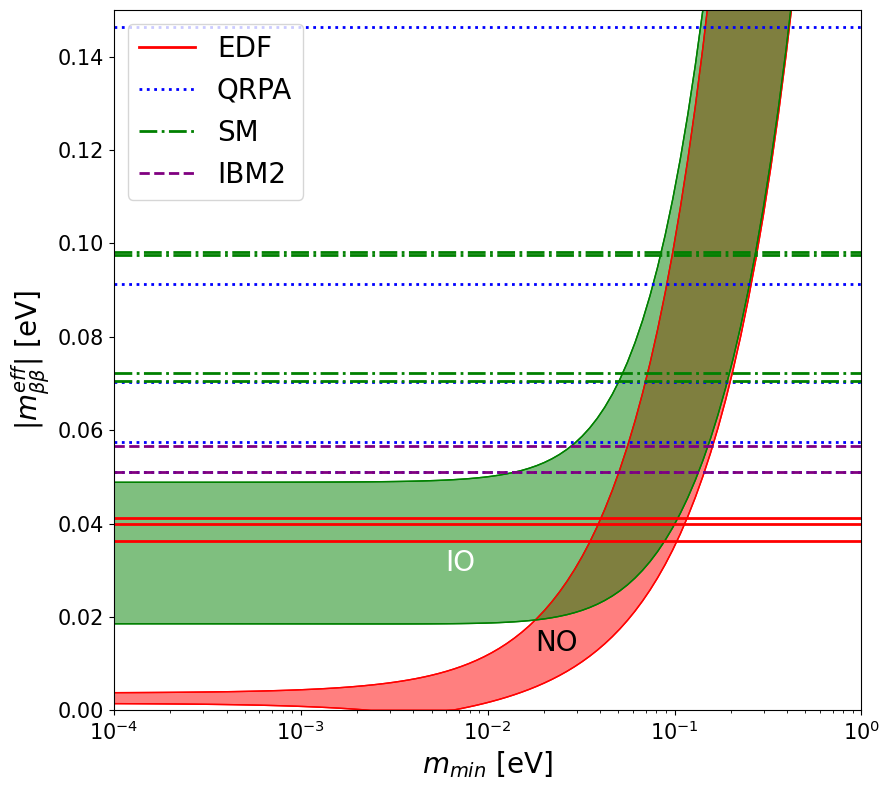

In [16]:
fig.text(0.6, 0.18, "NO", fontsize = 20, color = "k")
fig.text(0.5, 0.28, "IO", fontsize = 20, color = "w")
fig

Save the figure as PNG

In [17]:
fig.savefig("KamLAND-Zen_limits.png", dpi = 300)

# Recreating the KamLAND-Zen limits including the new short-range contribution

We now want to generate the limit plot with the additional contribution generated by the exchange of hard neutrinos, i.e, with non-vanishing $g_\nu^{NN}$. In the three frameworks available to us, namely SM, QRPA and IBM2, the short-range NME $M_{F,sd}$ is on average $\sim-1/2$ times (SM, QRPA) or $\sim-1/4$ times (IBM2) the size of the NME for the standard neutrino exchange $M_\nu$. As $M_{F,sd}$ is not calculated in all NME models we approximate it by the lower estimate $$M_{F,sd} = -\frac{1}{4}M_\nu$$
Note that the short-range contribution is constructive as $g_\nu^{NN}$ is negative.

In [18]:
short_range_ratios = pd.DataFrame([], ["Mean", "STD"])

for method in ["SM", "QRPA", "IBM2"]:
    #generate a model class
    model = LEFT({}, method = method)
    Mnu = (- 1/g_A**2 * model.NMEpanda.loc["F"] 
       + (model.NMEpanda.loc["GTAA"] 
          + model.NMEpanda.loc["GTAP"] 
          + model.NMEpanda.loc["GTPP"] 
          + model.NMEpanda.loc["GTMM"])
       + ( 
          + model.NMEpanda.loc["TAP"] 
          + model.NMEpanda.loc["TPP"] 
          + model.NMEpanda.loc["TMM"])
      )
    
    
    
    short_range_ratios[method] = [(model.NMEpanda.loc["Fsd"]/Mnu).mean(), 
                                  (model.NMEpanda.loc["Fsd"]/Mnu).std()]
short_range_ratios

,SM,QRPA,IBM2
Mean,-0.525806,-0.675523,-0.251354
STD,0.057140,0.103171,0.046652


We can now estimate the limits on $m_{\beta\beta}$ assuming that $M_{F,sd} = -\frac{1}{4}M_\nu$

In [19]:
model.NMEpanda.iloc[2].astype(float)

76Ge    -0.857155
82Se    -0.714296
96Zr    -0.642866
100Mo   -0.904775
110Pd   -0.761916
116Cd   -0.547627
124Sn   -0.500007
128Te   -0.642866
130Te   -0.571437
134Xe   -0.619056
136Xe   -0.452387
148Nd   -0.476197
150Nd   -0.761916
154Sm   -0.523817
160Gd   -0.714296
198Pt   -0.500007
232Th   -0.761916
238U    -0.904775
Name: GTAP, dtype: float64

In [20]:
#    Note, this part of the script will generate warnings
#    These are caused by setting several NMEs to 0 such that 
#    the get_limits() function divides by zero for some mechanisms.
#    Since we only care about the mass mechanism we can ignore these
#    warnings for our purpose.
new_limits = {}
scaling = -1/5
for nme in NMEs:
    model = LEFT({}, method = nme)
    model.PSFpanda["136Xe"]["G01"] = G01
    if MFsd[nme] == 0:
        model.NMEs["136Xe"]["F,sd"] = scaling*model.NMEs["136Xe"]["GTAA"]
    else:
        model.NMEs["136Xe"]["F,sd"] = MFsd[nme]*m_e*m_p/m_pi**2
        
    new_limits[nme] = model.get_limits(half_life, "136Xe")["Limits"]["m_bb"] * 1e+9
pd.DataFrame({r"$m_{\beta\beta}$": list(new_limits.values())}, list(new_limits.keys())).T

/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-main/ExampleNotebooks/../src/EFT.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  return(1/inverse_result)
/Users/scholer/Downloads/nudobe-ma

,EDF(1),EDF(2),EDF(3),QRPA(1),QRPA(2),QRPA(3),QRPA(4),QRPA(5),IBM2(1),IBM2(2),SM(1),SM(2),SM(3),SM(4)
$m_{\beta\beta}$,0.024991,0.027611,0.0284,0.026917,0.035248,0.048488,0.063111,0.062396,0.034338,0.036846,0.049908,0.067773,0.06739,0.032482


with new limits in the range of

In [21]:
min(new_limits.values())

0.024990717344993564

In [22]:
max(new_limits.values())

0.06777312152707628

## Generate Figure

Generating Datapoints...
Datapoints Generated
Preparing plot...
Generating plot


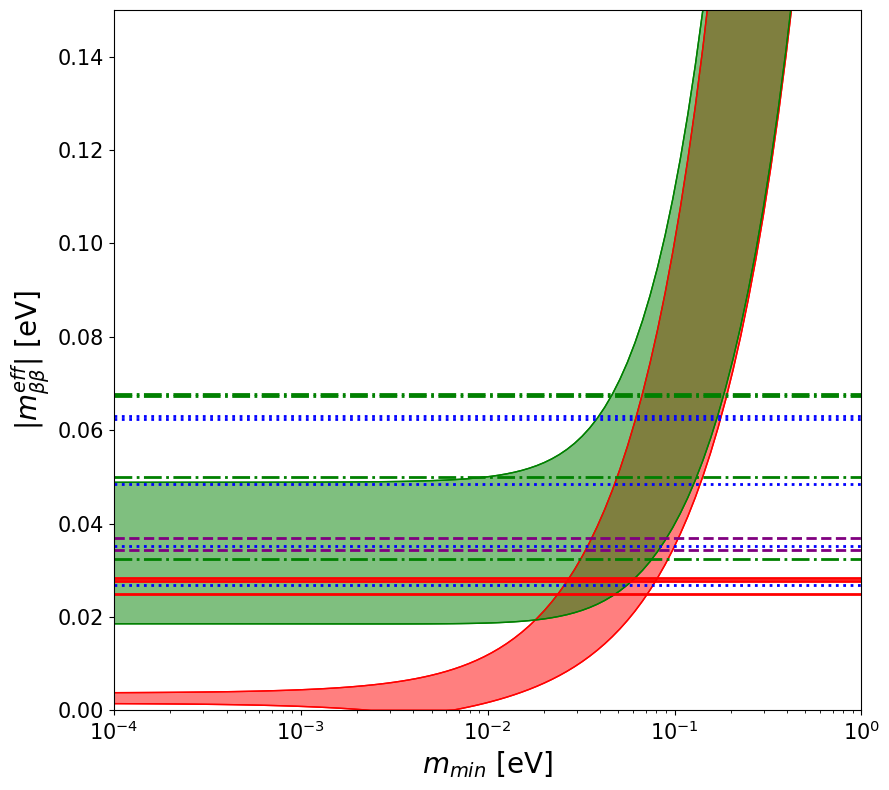

In [23]:
linewidth = 2
plotlims = {"EDF(1)"  : {"limit"     : new_limits["EDF(1)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth, 
                         "label"     : "EDF"}, 
            "EDF(2)"  : {"limit"     : new_limits["EDF(2)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth}, 
            "EDF(3)"  : {"limit"     : new_limits["EDF(3)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth},
            "QRPA(1)" : {"limit"     : new_limits["QRPA(1)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth, 
                         "label"     : "QRPA"}, 
            "QRPA(2)" : {"limit"     : new_limits["QRPA(2)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(3)" : {"limit"     : new_limits["QRPA(3)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(4)" : {"limit"     : new_limits["QRPA(4)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(5)" : {"limit"     : new_limits["QRPA(5)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "SM(1)"   : {"limit"     : new_limits["SM(1)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth, 
                         "label"     : "SM"}, 
            "SM(2)"   : {"limit"     : new_limits["SM(2)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth},
            "SM(3)"   : {"limit"     : new_limits["SM(3)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "SM(4)"   : {"limit"     : new_limits["SM(4)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "IBM2(1)" : {"limit"     : new_limits["IBM2(1)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth, 
                         "label"     : "IBM2"},
            "IBM2(2)" : {"limit"     : new_limits["IBM2(2)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth}}
fig = LEFT({}).plot_m_eff(limits    = plotlims, 
                          autolabel = False, 
                          colorNO   = "red", 
                          colorIO   = "green", 
                          y_max     = 0.15,
                          y_min     = 0,
                          yscale    = "linear",
                          legend    = False,
                         )

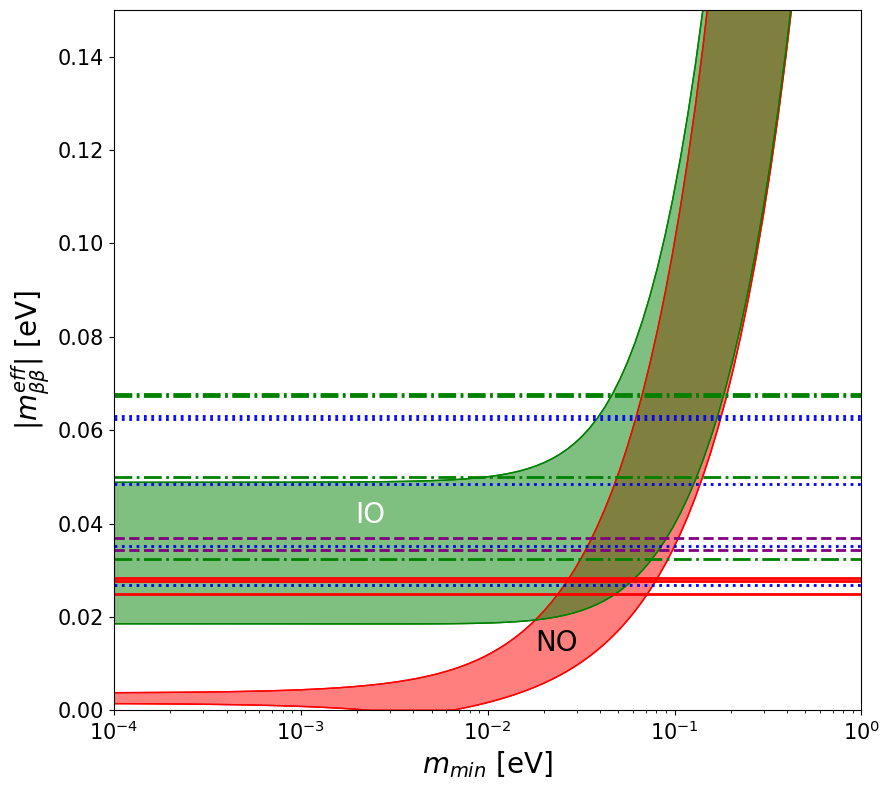

In [24]:
fig.text(0.6, 0.18, "NO", fontsize = 20, color = "k")
fig.text(0.4, 0.34, "IO", fontsize = 20, color = "w")
fig

In [25]:
fig.savefig("KamLAND-Zen_limits_short_range.png", dpi = 300)

# Adding Cosmology Limits

Generating Datapoints...
Datapoints Generated
Preparing plot...
Generating plot


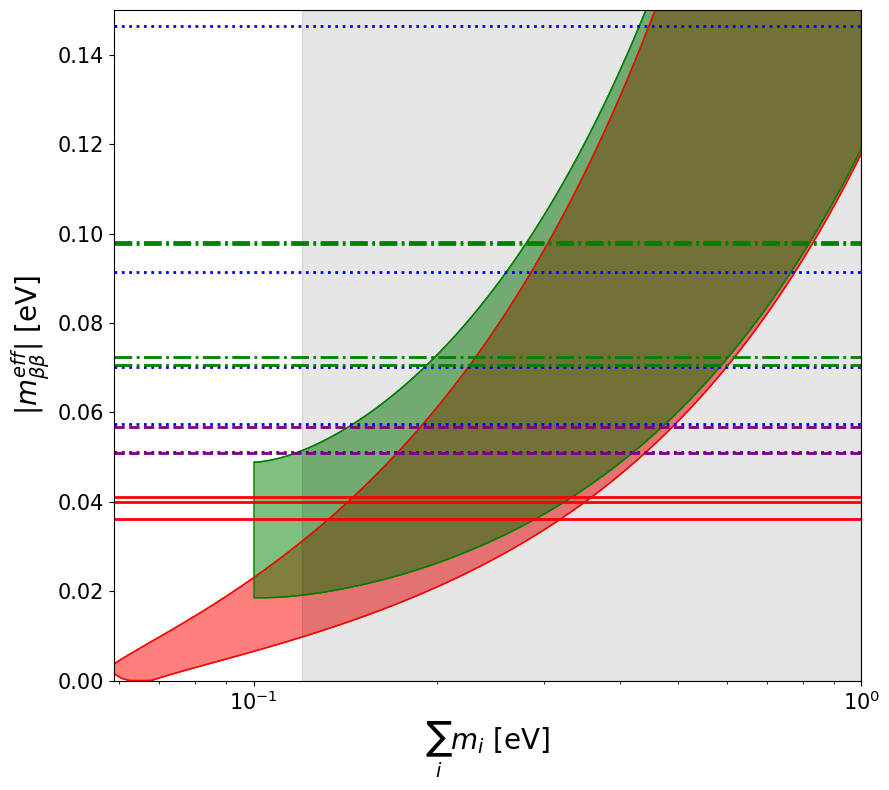

In [26]:
linewidth = 2
plotlims = {"EDF(1)"  : {"limit"     : limits["EDF(1)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth, 
                         "label"     : "EDF"}, 
            "EDF(2)"  : {"limit"     : limits["EDF(2)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth}, 
            "EDF(3)"  : {"limit"     : limits["EDF(3)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth},
            "QRPA(1)" : {"limit"     : limits["QRPA(1)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth, 
                         "label"     : "QRPA"}, 
            "QRPA(2)" : {"limit"     : limits["QRPA(2)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(3)" : {"limit"     : limits["QRPA(3)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(4)" : {"limit"     : limits["QRPA(4)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(5)" : {"limit"     : limits["QRPA(5)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "SM(1)"   : {"limit"     : limits["SM(1)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth, 
                         "label"     : "SM"}, 
            "SM(2)"   : {"limit"     : limits["SM(2)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth},
            "SM(3)"   : {"limit"     : limits["SM(3)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "SM(4)"   : {"limit"     : limits["SM(4)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "IBM2(1)" : {"limit"     : limits["IBM2(1)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth, 
                         "label"     : "IBM2"},
            "IBM2(2)" : {"limit"     : limits["IBM2(2)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth}}
fig = LEFT({}).plot_m_eff(xaxis     = "m_sum",
                          cosmo     = True,
                          m_cosmo   = 0.12,
                          limits    = plotlims, 
                          autolabel = False, 
                          colorNO   = "red", 
                          colorIO   = "green", 
                          yscale    = "linear", 
                          y_max     = 0.15, 
                          y_min     = 0,
                          x_min     = 0.05,
                          legend    = False,
                         )

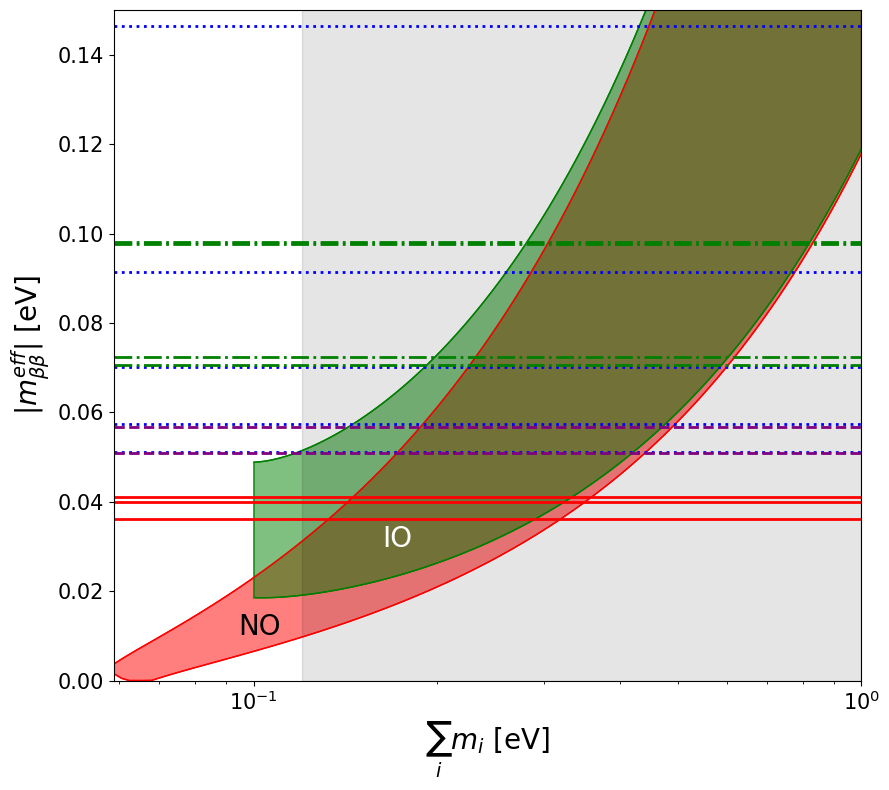

In [27]:
fig.text(0.27, 0.2, "NO", fontsize = 20, color = "k")
fig.text(0.43, 0.31, "IO", fontsize = 20, color = "w")

fig.savefig("KamLAND-Zen_limits_cosmo.png", dpi = 300)
fig

Generating Datapoints...
Datapoints Generated
Preparing plot...
Generating plot


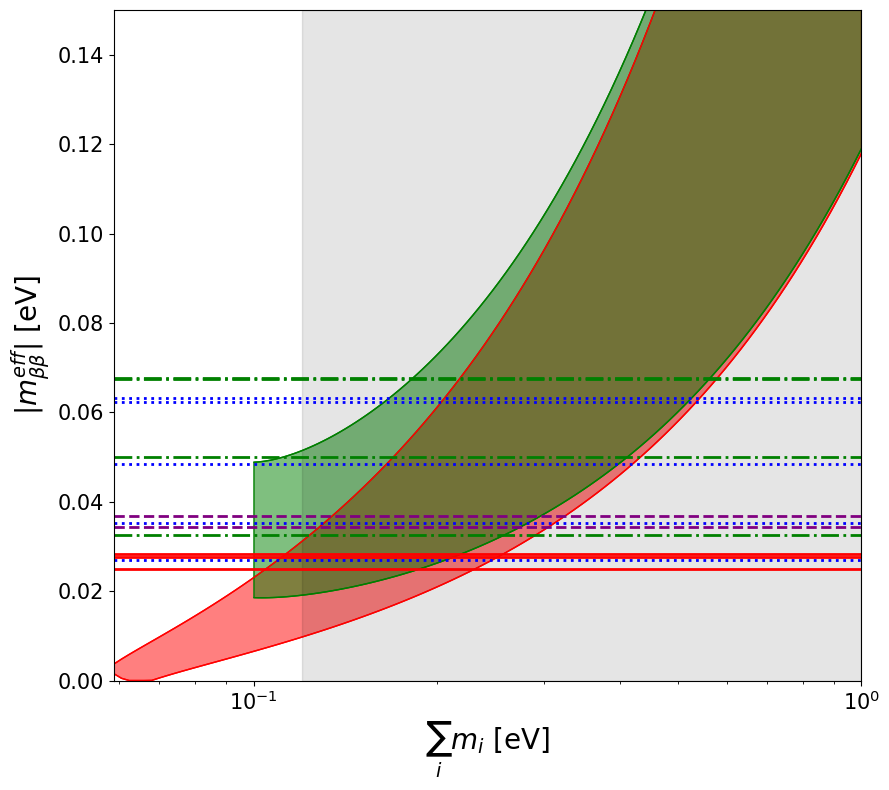

In [28]:
linewidth = 2
plotlims = {"EDF(1)"  : {"limit"     : new_limits["EDF(1)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth, 
                         "label"     : "EDF"}, 
            "EDF(2)"  : {"limit"     : new_limits["EDF(2)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth}, 
            "EDF(3)"  : {"limit"     : new_limits["EDF(3)"],
                         "color"     : "red",
                         "linestyle" : "-", 
                         "linewidth" : linewidth},
            "QRPA(1)" : {"limit"     : new_limits["QRPA(1)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth, 
                         "label"     : "QRPA"}, 
            "QRPA(2)" : {"limit"     : new_limits["QRPA(2)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(3)" : {"limit"     : new_limits["QRPA(3)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(4)" : {"limit"     : new_limits["QRPA(4)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "QRPA(5)" : {"limit"     : new_limits["QRPA(5)"],
                         "color"     : "blue",
                         "linestyle" : "dotted", 
                         "linewidth" : linewidth}, 
            "SM(1)"   : {"limit"     : new_limits["SM(1)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth, 
                         "label"     : "SM"}, 
            "SM(2)"   : {"limit"     : new_limits["SM(2)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth},
            "SM(3)"   : {"limit"     : new_limits["SM(3)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "SM(4)"   : {"limit"     : new_limits["SM(4)"],
                         "color"     : "green",
                         "linestyle" : "-.", 
                         "linewidth" : linewidth}, 
            "IBM2(1)" : {"limit"     : new_limits["IBM2(1)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth, 
                         "label"     : "IBM2"},
            "IBM2(2)" : {"limit"     : new_limits["IBM2(2)"],
                         "color"     : "purple",
                         "linestyle" : "--", 
                         "linewidth" : linewidth}}
fig = LEFT({}).plot_m_eff(xaxis = "m_sum",
                          cosmo = True,
                          m_cosmo = 0.12, #PDG limit https://pdg.lbl.gov/2022/reviews/rpp2022-rev-sum-neutrino-masses.pdf
                          limits    = plotlims, 
                          autolabel = False, 
                          colorNO   = "red", 
                          colorIO   = "green", 
                          y_max     = 0.15, 
                          y_min     = 0,
                          yscale    = "linear", 
                          x_min     = 0.05,
                          legend    = False,
                         )

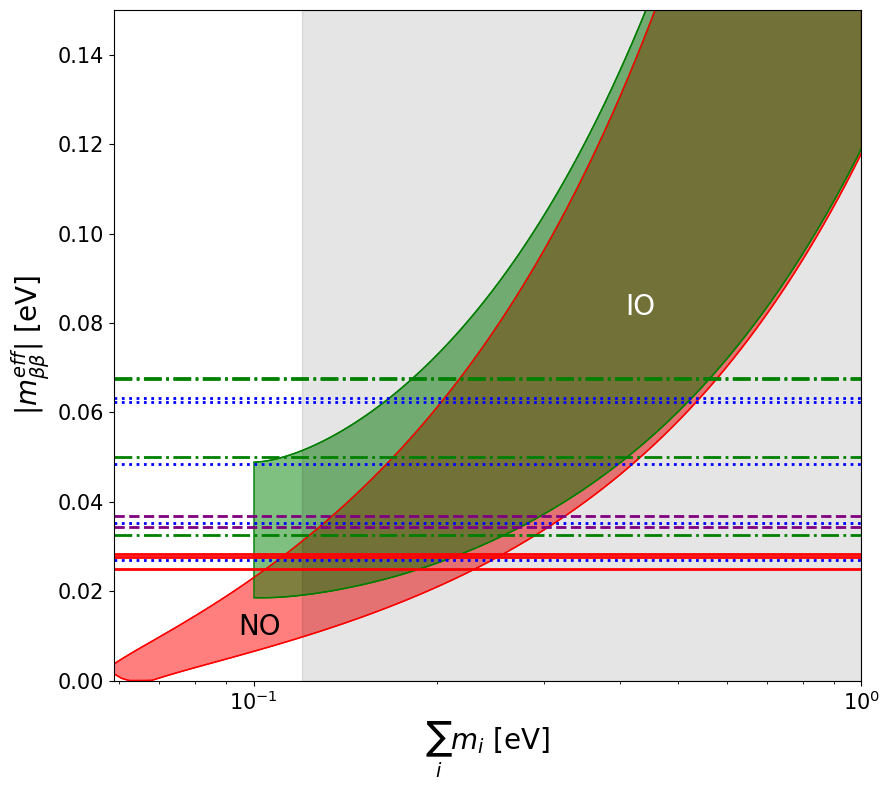

In [29]:
fig.text(0.27, 0.2, "NO", fontsize = 20, color = "k")
fig.text(0.7, 0.6, "IO", fontsize = 20, color = "w")
fig.savefig("KamLAND-Zen_limits_short_range_cosmo.png", dpi = 300)
fig

# Limits on non-standard mechanisms

Let's now study limits on all LEFT operators of interest. Here, we only consider the complete set of NMEs provided in nudobe.

In [30]:
#define a limit DataFrame
limitdf = pd.DataFrame()

In [31]:
for method in ["SM", "QRPA", "IBM2"]:
    limitdf[method] = f.get_limits_LEFT(2.3e+26, 
                                        "136Xe", 
                                        method = method, 
                                        groups = True)["Limits"].drop(["m_bb"], axis = 0)

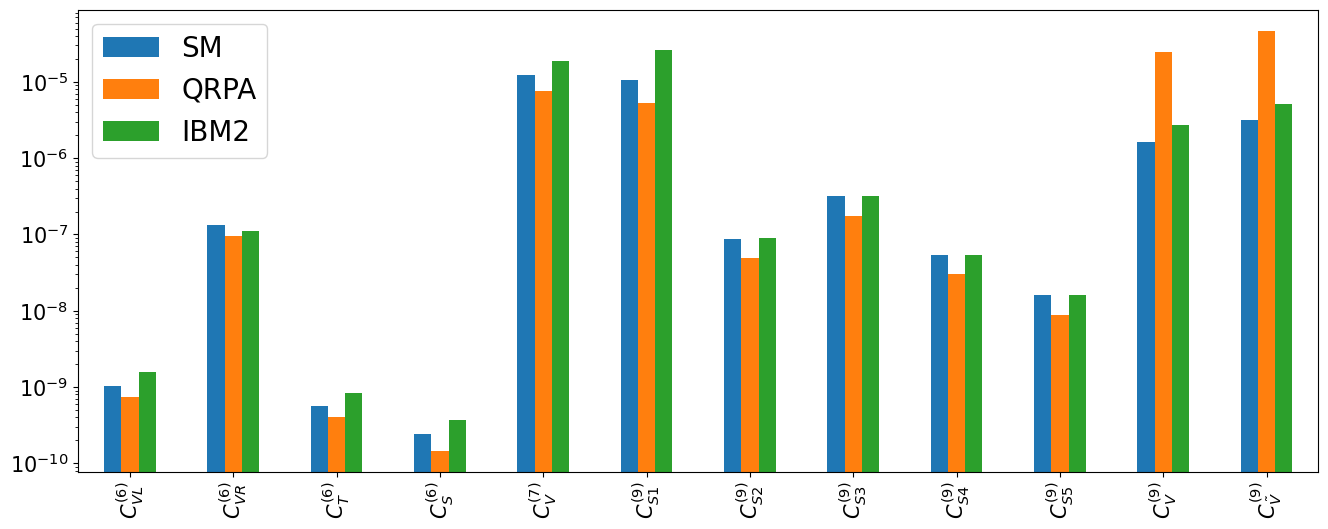

In [32]:
plt.rc("ytick", labelsize = 15)
plt.rc("xtick", labelsize = 15)
fig = limitdf.plot.bar(figsize = (16,6))
plt.yscale("log")
fig.set_xticklabels([#r"$m_{\beta\beta}$ [eV]",
                     r"$C_{VL}^{(6)}$", 
                     r"$C_{VR}^{(6)}$", 
                     r"$C_{T}^{(6)}$", 
                     r"$C_{S}^{(6)}}$", 
                     r"$C_{V}^{(7)}$", 
                     r"$C_{S1}^{(9)}$", 
                     r"$C_{S2}^{(9)}$", 
                     r"$C_{S3}^{(9)}$", 
                     r"$C_{S4}^{(9)}$", 
                     r"$C_{S5}^{(9)}$", 
                     r"$C_{V}^{(9)}$", 
                     r"$C_{\tilde{V}}^{(9)}$"], fontsize = 15)
plt.legend(fontsize = 20)
plt.savefig("KamLAND-ZenOperatorLimits.png", dpi = 150)

Now we want estimate limits on the scale of new physics $\Lambda$ set by the recent KamLAND-Zen results assuming different NMEs.

In [33]:
#Assuming new physics is generated in a LEFT like setting
scaledf = limitdf.copy()
for row in limitdf.index:
    scaledf.loc[row] = vev/limitdf.loc[row]**(1/(int(row[-2])-4))
scaledf.min()

SM      2438.862500
QRPA    1807.864536
IBM2    2026.261375
dtype: float64

In [34]:
scaledf.max()

SM      1.576556e+07
QRPA    2.035325e+07
IBM2    1.286708e+07
dtype: float64

## SMEFT

In [35]:
#define a limit DataFrame
limitdf_SMEFT = pd.DataFrame()

for method in ["SM", "QRPA", "IBM2"]:
    limitdf_SMEFT[method] = f.get_limits_SMEFT(2.3e+26, 
                                               "136Xe", 
                                               method = method)["Limits [GeV$^{4-d}$]"].drop(["LH(5)", "LH(7)"], axis = 0)

In [36]:
#Assuming new physics is generated in SMEFT with full matching onto LEFT
scaledfSMEFT = pd.DataFrame()
for method in ["SM", "QRPA", "IBM2"]:
    scaledfSMEFT[method] = f.get_limits_SMEFT(2.3e+26, 
                                        "136Xe", 
                                        method = method, 
                                        groups = False)["Scales [GeV]"].drop(["LH(5)", "LH(7)"])
scaledfSMEFT.min()

SM      1848.312147
QRPA    1781.045426
IBM2    1321.972343
dtype: float64

In [37]:
scaledfSMEFT.max()

SM      350977.745444
QRPA    416130.130932
IBM2    306520.850763
dtype: float64

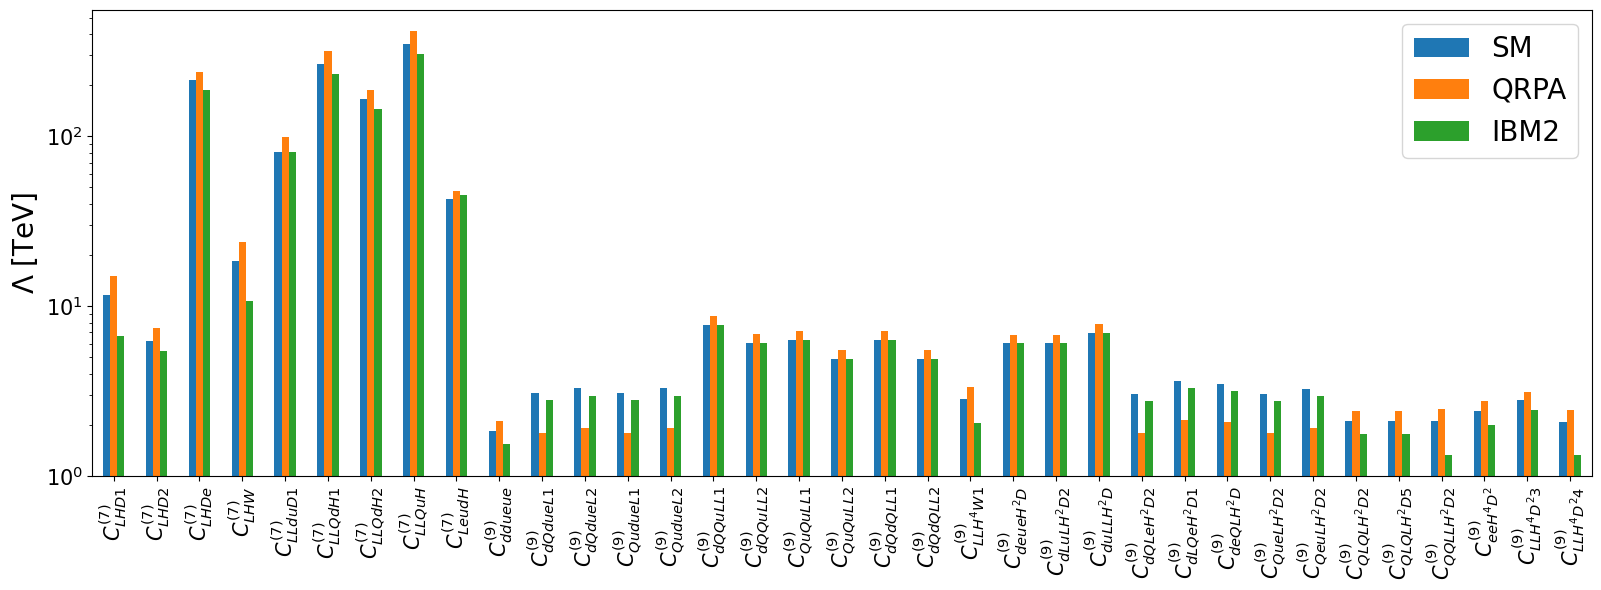

In [38]:
plt.rc("ytick", labelsize = 15)
plt.rc("xtick", labelsize = 15)
fig = (scaledfSMEFT/1000).plot.bar(figsize = (16,6))
plt.yscale("log")
fig.set_xticklabels(SMEFT_WCs_latex[2:], fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout(rect = (.015, 0, 1, 1))
plt.ylabel(r"$\Lambda$ [TeV]", fontsize = 20)
plt.savefig("KamLAND-ZenOperatorScaleLimits_SMEFT.png", dpi = 150)

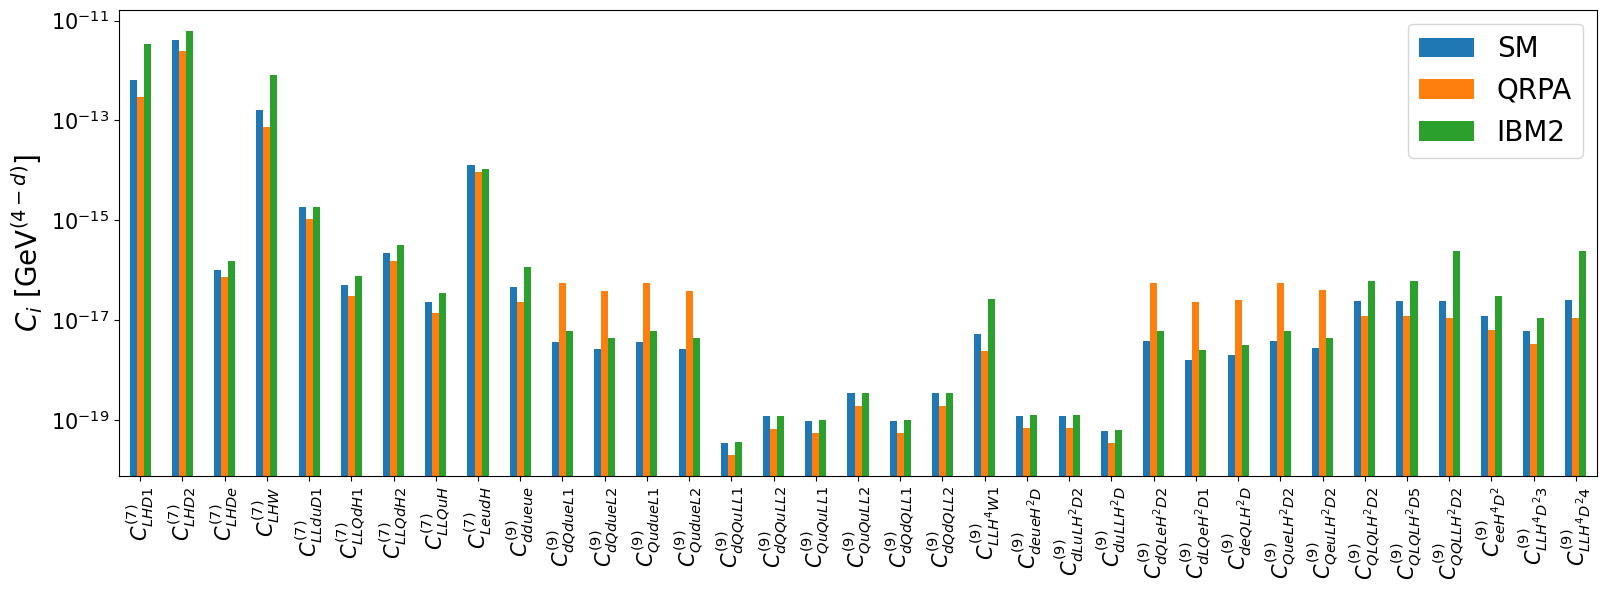

In [39]:
plt.rc("ytick", labelsize = 15)
plt.rc("xtick", labelsize = 15)
fig = limitdf_SMEFT.plot.bar(figsize = (16,6))
plt.yscale("log")
fig.set_xticklabels(SMEFT_WCs_latex[2:], fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout(rect = (.015, 0, 1, 1))
plt.ylabel(r"$C_i$ [GeV$^{(4-d)}$]", fontsize = 20)
plt.savefig("KamLAND-ZenOperatorLimits_SMEFT.png", dpi = 150)